# Deep Learning-Based Compressed Sensing under IQ Imbalance For Channel Estimation of mmWave Phased Arrays
- Institution: TU Delft
- Faculty: Mechanical Engineering
- Authors: Tom Lijding and Daan van Haasteren

### Python and Package Versions
- Python: 3.11.11
- Numpy: 2.2.1
- Scipy: 1.15.0
- Matplotlib: 3.10.0
- Pytorch: 2.5.1

### Introduction
This code demonstrates the use of a autoencoder based compressed sensing algorithm in channel estimation under IQ imbalance. We refer the reader to the file "Data_Compression_Deep_Learning_based_CS_under_IQ_Imbalance.pdf" for a full report and nice visuals!

### Structure
The code is structured as follows. First, the dataset is built upon which we train the neural networks. Next we create the neural networks i.e. build the custom layer "ComplexLinearUnitary" which functions as the encoding layer, and build the architecture of the autoencoders via the Pytorch framework. We then define a standard function to train the neural networks which we use for the rest of the code. We train models for varying parameters i.e. SNR, IQ imbalance and encoding dimensions in that order. We then validate the models on a new training set and plot the results. We then define a new function to train models for limited resolution phased-array antennas, train a set of models and validate those as well. We finish with some code snippets to visualize the reconstruction of the original signal for a given model.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math
plt.rcParams.update(plt.rcParamsDefault)

# Section 1: Building the dataset
In this section we build the dataset by generating a set of $K=10000$ random vectors of size $N=100$ with a range of sparsities. Currently, this is set to $7-9$ but these can range from $3-30$. The datasets are made by taking the DFT of these random vectors, thus making the resulting dataset dense! Following this, the vectors are tensorized for the Pytorch architecture and segmented for Epoch training.

### Define our buildDataSet function here!

In [2]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data


### Build the dataset

In [3]:
max_amplitude = 100
min_sparsity = 7
max_sparsity = 9
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


### Test the dataset (optional)

In [4]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse, should be nearly all zeros
# print(iDFT@dense_data)


From the above results, we can see that our vectors are very sparse if we take the IDFT

### Setting up the dataset for Pytorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

# Generate dataset
def Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size):
    # Function takes as inputs the (maximum) amplitude of the signal, minimum and maximum sparsity of the signal, the signal length (vector_size) and the size of the dataset
    # Outputs dataloader and signal variance, which is important for normalization
    dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

    X = np.concatenate((dense_data.real,dense_data.imag)).T
    Y = np.concatenate((dense_data.real,dense_data.imag)).T

    X_tensor = torch.tensor(X,dtype=torch.float)
    Y_tensor = torch.tensor(Y,dtype=torch.float)
    dataset = TensorDataset(X_tensor,Y_tensor)

    dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
    variance = np.var(Y)
    return dataloader, variance

dataloader, signal_variance = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


### Creating a function to validate our models
This function serves to take in a dataset and a model and gives us the loss of the model on that dataset

In [6]:
def validateModels(dataloader,models,loss_fn,signal_variance=133):
    models_losses = []
    with torch.no_grad():
        for model in models:
            current_model_losses = []
            model.eval()
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                output = model(inputs)
                loss = loss_fn(output, targets)
                current_model_losses.append(loss.item())
            models_losses.append(np.average(current_model_losses))

    models_losses = np.array(models_losses)
    normalized_models_losses = models_losses/signal_variance
    return normalized_models_losses,models_losses

### Create a visualization function
This function takes in a model which we have built, generates an input vector, runs it through the model and plots the input and output vectors

In [7]:
def visualizeReconstruction(model,max_amplitude=100,min_sparsity=3,max_sparsity=5,vector_size=100):
    h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

    H = np.concatenate((h.real,h.imag)).T

    H_tensor = torch.tensor(H,dtype=torch.float)

    H_hat = model(H_tensor)

    h_hat = np.array(H_hat.detach())

    h_real,h_imag = np.split(h_hat,2,1)
    h_hat = h_real + 1j*h_imag
    h_hat = h_hat.reshape(-1,1)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    iDFT = DFT.conj().T

    x_hat = iDFT@h_hat
    indices = range(len(x_hat))

    plt.vlines(indices,0,x,linewidth=3)
    plt.vlines(indices,0,x_hat,colors="orange")

    plt.legend(("x","x_hat"))

# Section 2: Building the neural network architecture
In this section we actually build the neural network architecture! We define a custom layer, namely ComplexLinearUnitary, to be able to fulfill the physical restrictions of the phased-array antenna. We refer the interested reader to our paper for more on how this is done!

## Setting up the Neural Networks

In [8]:

def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    # If we do not do this the neural network initializes at a *very* bad initial point and we get terrible convergence
    # Only applicable for the ComplexLinear layer
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexLinearUnitary(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexLinearUnitary,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # This custom layer was found to work less well than a regular linear layer, probably because we put restrictions on the network allowing it to be less expressive.
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)

# It should be noted that all previous autoencoders are less general versions of this neural network architecture. 
# If we set the IQ imbalance to 0 and the SNR to inf(), then we get previous architectures
class LearnedAutoencoderWithIQImbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,b, d,variance):
        super(LearnedAutoencoderWithIQImbalance, self).__init__()
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        self.r = torch.tensor(0.5*(1+b*np.exp(1j*d)), dtype=torch.complex64)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        y_real = encoder_out[:, :self.encoding_dim]
        y_imag = encoder_out[:, self.encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conj()) * (y.conj())
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise_tensor = torch.tensor(noise_np,dtype=torch.float)
        y_iq_stack_noisy = yiqstack + noise_tensor
        return self.decoder(y_iq_stack_noisy)

# Section 3: Training the models
In this section we train the models. The models are trained for varying SNR, IRR and measurement sizes, in that order. The ranges for how these models were trained are

$$SNR \in \{2,5,8,11,14,17,20\}$$
$$IRR \in \{41.09,33.12, 23.53, 17.43, 12.85\}$$
$$M \in \{5, 10, 20, 30, 40, 50\}$$

### Define function for training the models

In [9]:
def trainModels(dataloader,SNR_values,imb_percentages,encoding_dims,epochs,signal_variance = 133,hidden_dims=[60,80]):
    # Function takes as inputs:
    # dataloader: The dataloader object of the training data set
    # SNR_values: Signal to noise ratios
    # imb_percentages: imbalance percentages
    # encoding_dims: Encoding dimensions
    # epochs: Maximum amount of epochs we want the model to run for
    # signal_variance: The variance of the original signal
    # hidden_dims: Hidden dimensions for the neural network
    # Returns the best model with corresponding MSELoss
    models = []
    for model_num,(SNR,imb_percentage,encoding_dim) in enumerate(zip(SNR_values,imb_percentages,encoding_dims)):
        abs_noise_ratio = 10**(SNR/10)
        variance = signal_variance/abs_noise_ratio
        b = 1 - (0.2 * imb_percentage)
        d = imb_percentage * np.pi/8
        hidden_dims = np.array([60,80])
        current_training_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        optimizer = torch.optim.Adam(current_training_model.parameters(), lr=1E-3, betas=(0.9,0.999))
        MSEloss_fn = nn.MSELoss()

        # Training loop
        losses = []
        lowest_loss = float("inf")
        for epoch in range(epochs):
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                optimizer.zero_grad()
                output = current_training_model(inputs)
                loss = MSEloss_fn(output, targets)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if loss< lowest_loss:
                lowest_loss = loss
                early_stopping_counter = 0
                best_model = current_training_model
            else:
                early_stopping_counter += 1
                if early_stopping_counter > 100:
                    current_training_model = best_model
                    print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                    break
            print(f"SNR:{SNR}, Imbalance Percentage:{imb_percentage}, Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
        models.append(best_model)
        losses.append(lowest_loss)
    return models, losses

### Train Noisy Models
Here is code to train a range of noisy models. The commented code allows us to train the full range of noisy models, while for illustration purposes we have only uncommented code which trains a single model for 100 epochs

#### Extra specifications
- IRR: $\infty$
- Encoding dimensions: 50
- Maximum epoch iteration: 10000
- Stop after how many epochs of no loss improvement: 100

In [10]:
# We define our signal to noise ratio as ranging from 2 to 20 dB

# Train full range of models
# SNR_list = [2,5,8,11,14,17,20]
# imb_percentages = [0,0,0,0,0,0,0]
# encoding_dims = [50,50,50,50,50,50,50]
# epochs = 10000

# Train one model for illustration purposes
SNR_list = [20]
imb_percentage_list = [0]
encoding_dim_list = [50]
epochs = 100

dataloader, signal_var = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

noisy_models, noisy_losses = trainModels(dataloader,SNR_list,imb_percentage_list,encoding_dim_list,epochs,signal_variance=signal_var)

SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 1, Loss: 133.698746
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 2, Loss: 131.732620
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 3, Loss: 122.236481
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 4, Loss: 109.716949
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 5, Loss: 92.745110
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 6, Loss: 84.419853
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 7, Loss: 77.329628
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 8, Loss: 68.364731
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 9, Loss: 65.272362
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 10, Loss: 62.976570
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 11, Loss: 57.509476
SNR:20, Imbalance Percentage:0, Encoding dimension:50, Epoch 12, Loss: 53.972767
SNR:20, Imbalance Percentage:0, E

### Save the Noisy Models (DO NOT RUN)
This will replace the existing models with (potentially) empty and/or untrained models)

In [ ]:
# for indx, (db, value) in enumerate(SNR.items()):
#     torch.save(noisy_models[indx].state_dict(), f"Models/noisy_models/sparsity_{min_sparsity}-{max_sparsity}/noisy_model_{db}_{min_sparsity}-{max_sparsity}.pt")

### Train the IQ imbalanced models

##### Extra specifications
- SNR: $\infty$
- Encoding dimensions: 50
- Maximum epoch iteration: 10000
- Stop after how many epochs of no loss improvement: 100

In [11]:
# Train full range of IQ imbalances

# SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
# imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
# encoding_dim_list = [50, 50, 50, 50, 50, 50]
# epochs = 10000

# Train one model for illustration purposes
SNR_list = [np.inf]
imb_percentage_list = [0.6]
encoding_dim_list = [50]
epochs = 100

dataloader, signal_var = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

imbalanced_models, imbalanced_losses = trainModels(dataloader,SNR_list,imb_percentage_list,encoding_dim_list,epochs,signal_variance=signal_var)

SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 1, Loss: 134.600922
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 2, Loss: 128.448624
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 3, Loss: 121.059418
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 4, Loss: 107.953758
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 5, Loss: 95.392067
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 6, Loss: 83.599434
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 7, Loss: 75.744804
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 8, Loss: 70.161743
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 9, Loss: 65.769478
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 10, Loss: 59.545551
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 11, Loss: 56.803959
SNR:inf, Imbalance Percentage:0.6, Encoding dimension:50, Epoch 12, Loss: 56.1183

### Save the IQ imbalanced models (DO NOT RUN)


In [ ]:
# Calculate the dB imbalance levels, we store them in the dictionary IRR_ratios such that we can extract it with the corresponding level imbalance
imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}
for level in imb_percentage_list:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)

# Uncomment to save
# for indx, items in enumerate(IRR_ratios):
#     torch.save(imbalanced_models[indx].state_dict(), f"Models/imbalanced_models/sparsity_{min_sparsity}-{max_sparsity}/imbalanced_model_{items:.3f}_{min_sparsity}-{max_sparsity}.pt")

{0: np.float64(inf), 0.04: np.float64(41.08929220065852), 0.1: np.float64(33.118820471594574), 0.3: np.float64(23.531709031336195), 0.6: np.float64(17.42758855859956), 1: np.float64(12.849459258668094)}


C:\Users\tomli\AppData\Local\Temp\ipykernel_28372\3041498516.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


### Train the models for varying encoding dimensions (i.e. measurement sizes)
##### Extra specifications
- IRR: $\infty$
- SNR: $\infty$
- Maximum epoch iteration: 10000
- Stop after how many epochs of no loss improvement: 100

In [12]:
# Train full range of IQ imbalances

# SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
# imb_percentage_list = [0, 0, 0, 0, 0, 0]
# encoding_dim_list = [5, 10, 20, 30, 40, 50]
# epochs = 10000

# Train one model for illustration purposes
SNR_list = [np.inf]
imb_percentage_list = [0]
encoding_dim_list = [30]
epochs = 100

dataloader, signal_var = Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

measurement_models, measurement_losses = trainModels(dataloader,SNR_list,imb_percentage_list,encoding_dim_list,epochs,signal_variance=signal_var)

SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 1, Loss: 136.731033
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 2, Loss: 129.219284
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 3, Loss: 126.585510
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 4, Loss: 114.593697
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 5, Loss: 101.799522
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 6, Loss: 92.503471
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 7, Loss: 88.437019
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 8, Loss: 80.028412
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 9, Loss: 78.121094
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 10, Loss: 74.967369
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 11, Loss: 71.134178
SNR:inf, Imbalance Percentage:0, Encoding dimension:30, Epoch 12, Loss: 69.941994
SNR:inf, Imbalance P

### Save the models for varying encoding dimensions (DO NOT RUN)

In [15]:
# for indx, encoding_dim in enumerate(encoding_dim_list):
#     torch.save(measurement_models[indx].state_dict(), f"Models/measurement_models/sparsity_{min_sparsity}-{max_sparsity}/measurement_model_{encoding_dim}_{min_sparsity}-{max_sparsity}.pt")

# Section 4: Initializing and validating pretrained models
In this section we initialize all of the pretrained models and validate on a new dataset! Note that we have trained until now over $(6+5+7) \cdot 4 = 72$ models!

### Initializing pretrained models
Here we initialize all of our pretrained models. 

In [14]:
sparsity_ranges = [(3, 5), (5, 7), (7, 9), (10, 30)]
measurement_sizes = [5, 10, 20, 30, 40, 50]
# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

imb_percentage_list = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}
for level in imb_percentage_list:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)

#empty dicts to store models in
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}


for i, (min_spars, max_spars) in enumerate(sparsity_ranges):

    #Initialize pretrained noisy models
    for db,abs in SNR.items():
        encoding_dim = 50
        variance = signal_variance/abs
        # Initialize model
        hidden_dims = np.array([60,80])
        noisy_pretrained_models[(i, db)] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
        noisy_pretrained_models[(i, db)].load_state_dict(torch.load(f"Models/noisy_models/sparsity_{min_spars}-{max_spars}/noisy_model_{db}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained imbalanced_models
    for level, db  in IRR_ratios.items():
        encoding_dim = 50
        variance = 0
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        imbalanced_pretrained_models[(i, level)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        imbalanced_pretrained_models[(i, level)].load_state_dict(torch.load(f"Models/imbalanced_models/sparsity_{min_spars}-{max_spars}/imbalanced_model_{level:.3f}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained measurement models
    for encoding_dim  in measurement_sizes:
        variance = signal_variance/SNR[17]
        level = 0.6
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        measurement_pretrained_models[(i, encoding_dim)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        measurement_pretrained_models[(i, encoding_dim)].load_state_dict(torch.load(f"Models/measurement_models/sparsity_{min_spars}-{max_spars}/measurement_model_{encoding_dim}_{min_spars}-{max_spars}.pt", weights_only=True))




C:\Users\tomli\AppData\Local\Temp\ipykernel_6064\3241679832.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


In [15]:

all_noisy_losses = []
all_imbalanced_losses = []
all_measurement_losses = []

loss_fn = nn.MSELoss()

for i, (min_spars, max_spars) in enumerate(sparsity_ranges):
    dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_spars, max_spars, vector_size, data_set_size)
    # Evaluate noisy models
    noisy_val_losses = []
    noisy_model_losses = []
    with torch.no_grad():
        for db, abs in SNR.items():
            noisy_model = noisy_pretrained_models[(i, db)]
            noisy_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = noisy_model(inputs)
                loss = loss_fn(output, targets)
                noisy_model_losses.append(loss.item())
            noisy_val_losses.append(np.average(noisy_model_losses))
            noisy_model_losses = []

    noisy_val_losses = np.array(noisy_val_losses)
    normalized_noisy_val_losses = noisy_val_losses/signal_variance
    all_noisy_losses.append(normalized_noisy_val_losses)

    # Evaluate Imbalanced models
    imbalance_model_losses = []
    imbalance_val_losses = []

    with torch.no_grad():
        for level, db in IRR_ratios.items():
            imbalance_model = imbalanced_pretrained_models[(i, level)]
            imbalance_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = imbalance_model(inputs)
                loss = loss_fn(output, targets)
                imbalance_model_losses.append(loss.item())
            imbalance_val_losses.append(np.average(imbalance_model_losses))
            imbalance_model_losses = []

    imbalance_val_losses = np.array(imbalance_val_losses)
    normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
    all_imbalanced_losses.append(normalized_imbalance_val_losses)

    # Evaluate models with varying measurement sizes
    measurement_model_losses = []
    measurement_val_losses = []

    with (torch.no_grad()):
        for encoding_dim in measurement_sizes:
            measurement_model = measurement_pretrained_models[(i, encoding_dim)]
            measurement_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = measurement_model(inputs)
                loss = loss_fn(output, targets)
                measurement_model_losses.append(loss.item())
            measurement_val_losses.append(np.average(measurement_model_losses))
            measurement_model_losses = []

    measurement_val_losses = np.array(measurement_val_losses)
    normalized_measurement_val_losses = measurement_val_losses/signal_variance
    all_measurement_losses.append(normalized_measurement_val_losses)



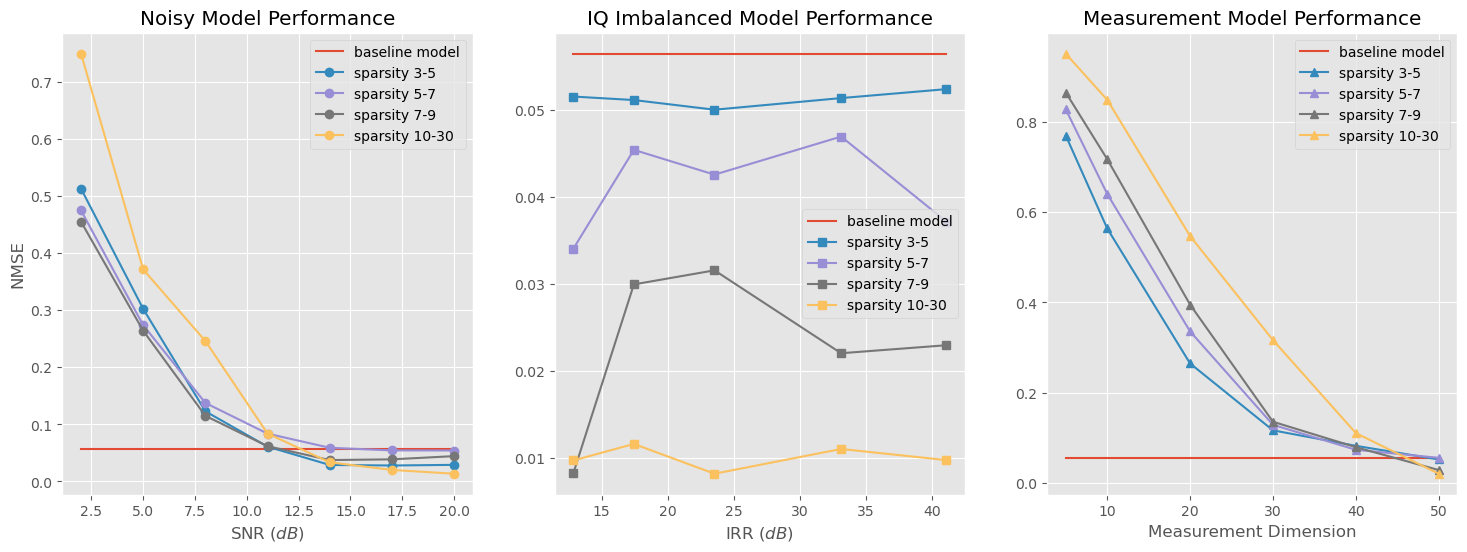

In [16]:
plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))

for i in range(4):
    if i==0:
        noiseless_loss = all_imbalanced_losses[0][0]
        ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
        ax2.plot(IRR_ratios.values(), [noiseless_loss for i in IRR_ratios.values()])
        ax3.plot(measurement_sizes, [noiseless_loss for i in measurement_sizes])

    ax1.plot(SNR.keys(), all_noisy_losses[i], marker="o")
    ax1.set_xlabel("SNR $(dB)$")
    ax1.set_ylabel("NMSE")
    ax1.set_title("Noisy Model Performance")
    ax1.grid(True)
    ax1.legend(["baseline model", "sparsity 3-5", "sparsity 5-7","sparsity 7-9", "sparsity 10-30"])

    ax2.plot(IRR_ratios.values(),all_imbalanced_losses[i],marker='s')
    ax2.set_xlabel("IRR $(dB)$")
    ax2.set_title("IQ Imbalanced Model Performance")
    ax2.legend(["baseline model", "sparsity 3-5","sparsity 5-7","sparsity 7-9", "sparsity 10-30"])
    ax2.grid(True)

    ax3.plot(measurement_sizes, all_measurement_losses[i],marker='^')
    ax3.set_xlabel("Measurement Dimension")
    ax3.set_title("Measurement Model Performance")
    ax3.legend(["baseline model", "sparsity 3-5","sparsity 5-7","sparsity 7-9", "sparsity 10-30"])
    ax3.grid(True)

plt.show()



# Section 5: Training limited resolution phased-array antenna setup
In this section we train new models for a limited resolution phased-array antenna setup. We restrict ourselves to a 5-bit setup, ranging from

$$q \in \{-\pi,-\frac{1}{2}\pi,0,\frac{1}{2}\pi,\pi\}$$

Note that of course this setup can be changed to any resolution, as the loss function is adjustable for any amount of zero's. We define a new loss function to regularize the optimization to prefer values of $q$ close to the defined range. The regularization term is defined as

$$g(q) = \lvert q(q-\frac{\pi}{2})(q-\pi)(q+\frac{\pi}{2})(q+\pi)\rvert$$

As we were not sure this approach would work, we show in this section a more detailed walk through of the process by showing the loss function, as well as the values of the CS matrix before mapping to discrete values.

## Section 5.1: Testing
In this section we test the new loss function and see if it works on the easiest case (noiseless, no IQ imbalance and encoding dimensions equal to 50).

### Create new loss function
This function is used in the Pytorch framework to drive the values of the measurement matrix to discrete values $\{-\pi,-\frac{1}{2}\pi,0,\frac{1}{2}\pi,\pi\}$

In [17]:
def discreteLossPoly(qweights,scaleFactor):
    loss = 0
    pi = torch.tensor(math.pi)
    # Note that we need to flatten the weights so that our iteration does not result in us iterating over the rows instead of the weights
    qVec = qweights.flatten()
    # Efficient implementation of the loss function, by doing vector operations, saves a lot of time in training
    loss += torch.linalg.vector_norm(qVec*(qVec-1/2*pi)*(qVec-1*pi)*(qVec+pi)*(qVec+1/2*pi),1)
    loss = loss*scaleFactor # Scale the resulting loss
    return loss

## Train neural network using new loss function

In [20]:
vector_size = 100
encoding_dim = 50
hidden_dims = np.array([60,80])
discrete_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(discrete_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
MSELossfn = nn.MSELoss()
scaleFactor = 0.05 # Hyperparameter, setting this too high causes the problem to not converge to low loss, due to the problem converging to discrete values too early, setting too low causes the
# values to not converge to discrete values. Empirical testing showed that scaleFactor of 0.05 was nice

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = discrete_autoencoder_model(inputs)
        qweights = discrete_autoencoder_model.encoder.q_values
        loss = discreteLossPoly(qweights,scaleFactor) + MSELossfn(output,targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss.item()
        early_stopping_counter = 0
        best_model = discrete_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            discrete_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs, with a loss of: {lowest_loss}")
            break

    print(f"Epoch {epoch+1}, Loss: {lowest_loss:.6f}")

plt.plot(losses)
plt.show()

Epoch 1, Loss: 2652.849121
Epoch 2, Loss: 2539.591064
Epoch 3, Loss: 2419.635742
Epoch 4, Loss: 2288.823975
Epoch 5, Loss: 2152.820557
Epoch 6, Loss: 2020.537476
Epoch 7, Loss: 1904.269287
Epoch 8, Loss: 1775.977295
Epoch 9, Loss: 1660.992432
Epoch 10, Loss: 1539.629639
Epoch 11, Loss: 1421.284912
Epoch 12, Loss: 1308.543579
Epoch 13, Loss: 1197.366699
Epoch 14, Loss: 1083.961426
Epoch 15, Loss: 975.611267
Epoch 16, Loss: 878.191284
Epoch 17, Loss: 779.404968
Epoch 18, Loss: 686.858337
Epoch 19, Loss: 601.232422
Epoch 20, Loss: 514.314392
Epoch 21, Loss: 442.869141
Epoch 22, Loss: 379.097412
Epoch 23, Loss: 325.136414
Epoch 24, Loss: 283.388275
Epoch 25, Loss: 247.474121
Epoch 26, Loss: 211.122253
Epoch 27, Loss: 183.420212
Epoch 28, Loss: 160.805664
Epoch 29, Loss: 142.387360
Epoch 30, Loss: 137.444611
Epoch 31, Loss: 128.375610
Epoch 32, Loss: 125.909225
Epoch 33, Loss: 121.106911
Epoch 34, Loss: 114.938255
Epoch 35, Loss: 114.938255
Epoch 36, Loss: 107.517677
Epoch 37, Loss: 107.517

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7aeea3415610>>
Traceback (most recent call last):
  File "/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Epoch 136, Loss: 67.552185
Epoch 137, Loss: 67.552185
Epoch 138, Loss: 67.552185
Epoch 139, Loss: 66.757339
Epoch 140, Loss: 66.757339
Epoch 141, Loss: 66.402916
Epoch 142, Loss: 65.579208
Epoch 143, Loss: 65.579208
Epoch 144, Loss: 65.579208
Epoch 145, Loss: 65.579208
Epoch 146, Loss: 65.579208
Epoch 147, Loss: 65.579208
Epoch 148, Loss: 65.579208
Epoch 149, Loss: 65.579208
Epoch 150, Loss: 65.579208
Epoch 151, Loss: 65.579208
Epoch 152, Loss: 65.298981
Epoch 153, Loss: 64.630455
Epoch 154, Loss: 64.630455
Epoch 155, Loss: 64.396919
Epoch 156, Loss: 64.396919
Epoch 157, Loss: 64.396919
Epoch 158, Loss: 62.576447
Epoch 159, Loss: 62.576447
Epoch 160, Loss: 62.576447
Epoch 161, Loss: 62.576447
Epoch 162, Loss: 62.576447
Epoch 163, Loss: 62.277275
Epoch 164, Loss: 62.277275
Epoch 165, Loss: 62.277275
Epoch 166, Loss: 60.932697


KeyboardInterrupt: 

### Show the values of the weights, they should be $\{0,\pm1.57079,\pm3.14159\}$

Notice that in fact, the values are not exactly in the above set but they are quite close!

In [120]:
print(discrete_autoencoder_model.encoder.q_values[0:20,0:20])

tensor([[-1.5707e+00,  1.6763e-04, -1.5708e+00,  1.5707e+00,  1.1577e-04,
          8.8554e-05, -1.5707e+00, -4.4146e-05, -8.0929e-05,  4.4981e-05,
          2.5490e-05,  3.1560e-05, -1.5709e+00,  1.4254e-05, -2.7892e-04,
          1.7612e-06,  1.7375e-05, -1.5710e+00, -1.5708e+00,  9.3605e-05],
        [-1.1979e-04,  2.9103e-05, -8.7400e-05,  1.5708e+00,  7.7426e-05,
          1.2997e-04, -1.2431e-04,  1.5707e+00, -1.3935e-04,  4.6723e-05,
         -1.5707e+00, -2.1258e-04, -1.5708e+00,  3.1502e-04,  1.5709e+00,
          1.5710e+00, -2.8735e-04,  1.7256e-04,  1.5706e+00,  1.5706e+00],
        [ 5.4674e-05,  1.0755e-04,  2.0990e-04, -1.5361e-04, -1.5709e+00,
         -1.5709e+00, -8.7036e-05,  5.9849e-06,  2.4989e-04, -2.2934e-04,
          1.5708e+00,  2.8368e-05, -1.5708e+00, -1.3945e-04, -1.0065e-04,
         -3.1415e+00, -1.5707e+00,  1.9150e-04,  2.7448e-05, -1.5707e+00],
        [-1.5706e+00,  2.9920e-04,  1.5708e+00,  1.9246e-04, -2.1294e-04,
         -1.5818e-04, -1.5708e+00, 

## Now we map all the values to actual discrete values

In [121]:
def mapToDiscreteValues(weights,discrete_values):
    # Input is a tensor (possibly a matrix) of weights, and a np array of discrete values
    discrete_values = discrete_values.flatten()
    weights_np = weights.detach().cpu().numpy() # Convert to numpy array
    shape = weights_np.shape
    weights_vector = np.reshape(weights_np,(-1,1)) # flatten the matrix to a vector such that subtracting from the discrete values results in a matrix!
    
    # Create a matrix of distances, then make a vector of indices from this matrix. Each value of the vector is the index of the closest discrete value
    distances = np.abs(weights_vector - discrete_values)
    indices = np.argmin(distances,1)

    # Map the weights to the closest discrete values and reshape into original matrix, and turn into a nn.Parameter object
    mappedWeights = discrete_values[indices]
    mappedWeights = np.reshape(mappedWeights,shape)
    mappedWeights = np.float32(mappedWeights) # Notice we map it to a float because that is what is used for our model
    mappedWeights = nn.Parameter(torch.from_numpy(mappedWeights))
    return mappedWeights

# Testing

qweights = discrete_autoencoder_model.encoder.q_values
discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
mapped_q_weights = mapToDiscreteValues(qweights,discrete_values)


mapped_discrete_autoencoder_model = discrete_autoencoder_model
mapped_discrete_autoencoder_model.encoder.q_values = mapped_q_weights


### Save the model (DO NOT RUN)
Again, will overwrite existing model with an empty model

In [116]:
# torch.save(mapped_discrete_autoencoder_model.state_dict(), f"Models/discrete_models/discrete_model.pt")

### Load discrete model

In [45]:
discrete_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
discrete_model.load_state_dict(torch.load("Models/discrete_models/discrete_model.pt"))

C:\Users\tomli\AppData\Local\Temp\ipykernel_28372\37869980.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discrete_model.load_state_dict(torch.load("Models/discrete_mod

<All keys matched successfully>

### Testing on a single datapoint
Here we test the neural network on a single vector and plot the results!

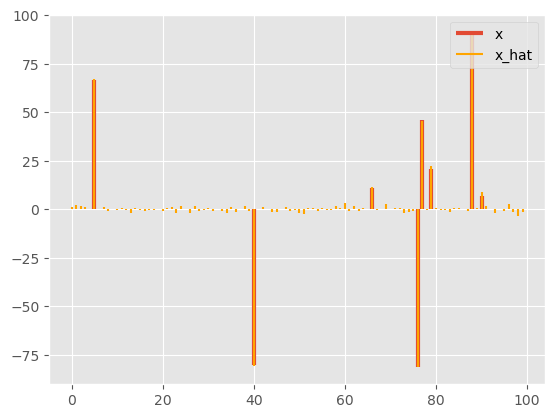

In [59]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output
visualizeReconstruction(discrete_model,max_amplitude,min_sparsity,max_sparsity,vector_size)

### And then we test on the validation data set!

In [60]:
discrete_model_losses = []

dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size)

loss_fn = nn.MSELoss()

# We need to put it in an array for our function to work!
discrete_models = [discrete_model]

normalized_loss, unnormalized_loss = validateModels(dataloader_val,discrete_models,loss_fn)

print(f"Normalized loss is:{normalized_loss}, Unnormalized loss is:{unnormalized_loss}")

Normalized loss is:[0.006498], Unnormalized loss is:[0.86423462]


## Section 5.2: Training range of models for restricted resolution
We have seen that the approach works! For this reason we train a range of models for the restricted resolution. We train for the following setups:

$$SNR \in \{2,5,8,11,14,17,20\}$$
$$IRR \in \{41.09,33.12, 23.53, 17.43, 12.85\}$$
$$M \in \{5, 10, 20, 30, 40, 50\}$$

and a sparsity of $7-9$

### Define discrete model training function
The code works! For this reason we then define a new function which makes the training for this limited resolution neural network much easier. Afterwards we train 19 models, to show our results!

In [ ]:
def trainModelsForDiscreteSet(dataloader,SNR_values,imb_percentages,encoding_dims,signal_variance = 133,hidden_dims=[60,80],scale_factor=0.05):
    # Function takes as inputs:
    # dataloader: The dataloader object of the training data set
    # SNR_values: Signal to noise ratios
    # imb_percentages: imbalance percentages
    # encoding_dims: Encoding dimensions
    # signal_variance: The variance of the original signal
    # hidden_dims: Hidden dimensions for the neural network
    # scale_factor: Hyperparameter for the discretization step
    models = []
    discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
    for model_num,(SNR,imb_percentage,encoding_dim) in enumerate(zip(SNR_values,imb_percentages,encoding_dims)):
        abs_noise_ratio = 10**(SNR/10)
        variance = signal_variance/abs_noise_ratio
        b = 1 - (0.2 * imb_percentage)
        d = imb_percentage * np.pi/8
        hidden_dims = np.array([60,80])
        current_training_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        optimizer = torch.optim.Adam(current_training_model.parameters(), lr=1E-3, betas=(0.9,0.999))
        MSEloss_fn = nn.MSELoss()

        # Training loop
        losses = []
        lowest_loss = float("inf")
        for epoch in range(10000):
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                optimizer.zero_grad()
                output = current_training_model(inputs)
                qweights = current_training_model.encoder.q_values
                loss = discreteLossPoly(qweights,scale_factor) + MSEloss_fn(output, targets)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if loss< lowest_loss:
                lowest_loss = loss
                early_stopping_counter = 0
                best_model = current_training_model
            else:
                early_stopping_counter += 1
                if early_stopping_counter > 100:
                    current_training_model = best_model
                    print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                    break
            print(f"SNR:{SNR}, Imbalance Percentage:{imb_percentage}, Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
        best_qvalues = best_model.encoder.q_values
        mapped_best_qvalues = mapToDiscreteValues(best_qvalues,discrete_values)
        best_model.encoder.q_values = mapped_best_qvalues
        models.append(best_model)
        losses.append(lowest_loss)
    return models

### Train all the models
Here we train the entire range of models. Notice how we give long lists of SNR,IRR and encoding dims so that it trains in one go.

In [13]:
# Train 19 models. Here we define a list of all combinations of SNR, IRR and encoding dimensions that we want our function to train the models for.
encoding_dims_list = [50, 40, 30, 20, 10, 5, 50, 50, 50, 50,50,50,50,50,50,50,50,50,50]
SNR_list = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 20, 17, 14, 11, 8, 5, 2, np.inf, np.inf,np.inf, np.inf,np.inf, np.inf]
imb_percentage_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0, 0.04, 0.1, 0.3, 0.6, 1]

In [ ]:
discrete_models = trainModelsForDiscreteSet(dataloader,SNR_list,imb_percentage_list,encoding_dims_list,scale_factor=0.01)

SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 1, Loss: 585.068726
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 2, Loss: 556.388489
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 3, Loss: 530.479309
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 4, Loss: 495.758881
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 5, Loss: 466.309326
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 6, Loss: 431.455505
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 7, Loss: 403.078278
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 8, Loss: 378.776428
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 9, Loss: 352.238953
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 10, Loss: 326.493805
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 11, Loss: 302.292175
SNR:inf, Imbalance Percentage:0, Encoding dimension:50, Epoch 12, Loss: 282.298615
SNR:inf, Imba

### Save the models (DO NOT RUN)

In [ ]:
# for iter,model in enumerate(discrete_models):
#     torch.save(model.state_dict(),f'Models/discrete_models/discrete_model_SNR{SNR_list[iter]}_IRR{imb_percentage_list[iter]}_enc{encoding_dims_list[iter]}.pt')

### Initialize the pretrained models
Here we initialize our pretrained models

In [61]:
discrete_models = []
for iter,__ in enumerate(SNR_list):
    abs_noise_ratio = 10**(SNR_list[iter]/10)
    variance = signal_variance/abs_noise_ratio
    b = 1 - (0.2 * imb_percentage_list[iter])
    d = imb_percentage_list[iter] * np.pi/8
    hidden_dims = np.array([60,80])
    discrete_models.append(LearnedAutoencoderWithIQImbalance(vector_size,encoding_dims_list[iter],hidden_dims,b,d,variance))
    discrete_models[iter].load_state_dict(torch.load(
        f'Models/discrete_models/discrete_model_SNR{SNR_list[iter]}_IRR{imb_percentage_list[iter]}_enc{encoding_dims_list[iter]}.pt', weights_only=True))

### Validate the models
Here we validate the models using our function. As well as show how the algorithm reconstructs a signal that it has been given! The signal that is reconstructed is for the model with $M = 30, SNR = \infty, IRR = \infty$

In [62]:
loss_fn = nn.MSELoss()
normalized_losses, unnormalized_losses = validateModels(dataloader_val,discrete_models,loss_fn)


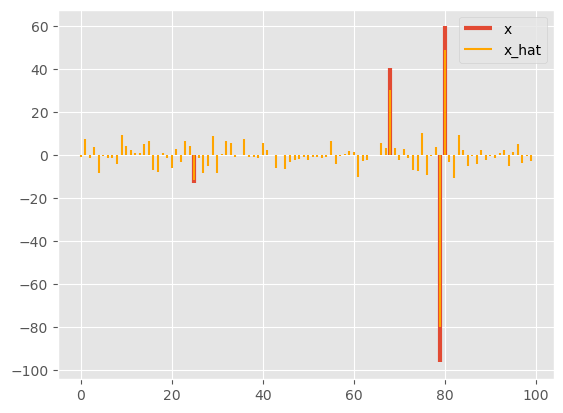

In [71]:
visualizeReconstruction(discrete_models[2])

## Plotting!

C:\Users\tomli\AppData\Local\Temp\ipykernel_28372\2689969186.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_abs = np.abs(r)**2/np.abs(1-r)**2


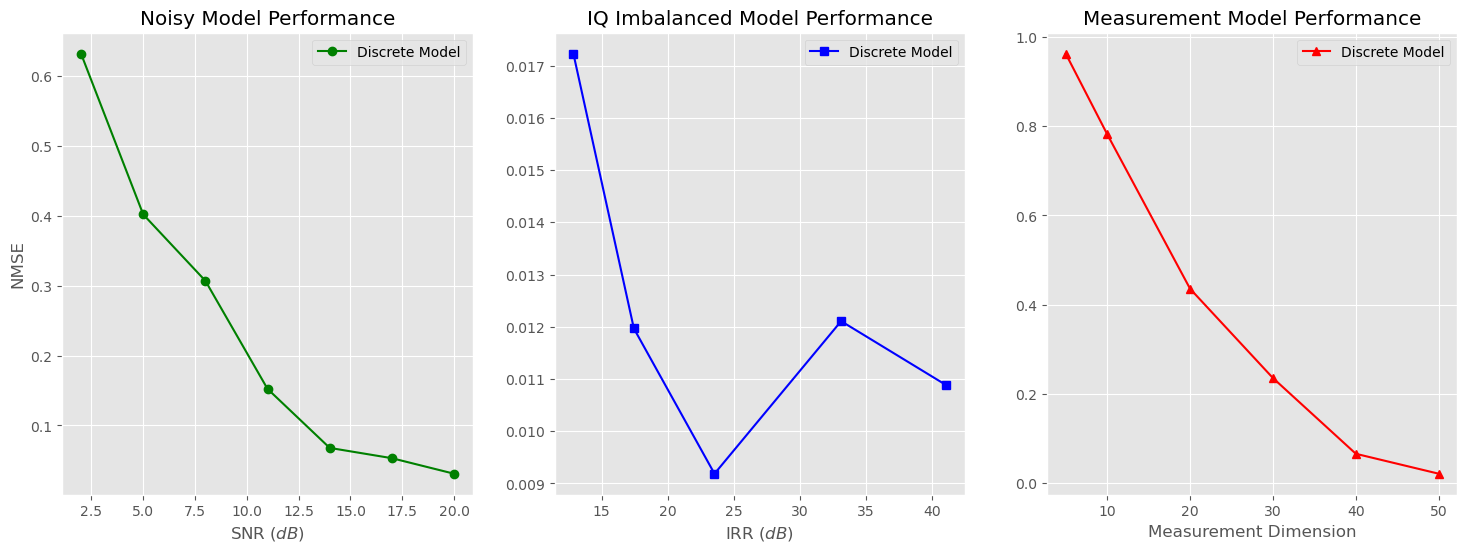

In [72]:
# Quick calculation for the sake of plotting
imb_db_list = []

for perc in imb_percentage_list[13:19]:
    b = 1-0.2*perc
    d = np.pi/8*perc
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_abs = np.abs(r)**2/np.abs(1-r)**2
    imb_db_list.append(10*np.log10(IRR_abs))


plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))


ax1.plot(SNR_list[6:13], normalized_losses[6:13],marker="o",color="g")
ax2.plot(imb_db_list, normalized_losses[13:20],marker='s',color='b')
ax3.plot(encoding_dims_list[0:6], normalized_losses[0:6],marker='^',color='r')

ax1.set_xlabel("SNR $(dB)$")
ax1.set_ylabel("NMSE")
ax1.set_title("Noisy Model Performance")
ax1.grid(True)
ax1.legend(["Discrete Model"])

ax2.set_xlabel("IRR $(dB)$")
ax2.set_title("IQ Imbalanced Model Performance")
ax2.legend(["Discrete Model"])
ax2.grid(True)

ax3.set_xlabel("Measurement Dimension")
ax3.set_title("Measurement Model Performance")
ax3.legend(["Discrete Model"])
ax3.grid(True)
plt.savefig("Images/discrete_model_performance.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Section 6: Theoretical guarantees
In this section we give some theoretical background. First we calculate the RIC of the models for a sparsity of $s=3$ and then we calculate the coherence of the above restricted encoding matrices.

# Find RIP from Model

In [ ]:
import itertools

# Create an array of 100 numbers (0 to 99)
numbers = list(range(100))
RIC = {}

# Generate all possible 3-length combinations
for model in discrete_models:
    max_RIC = 0
    # Get q-values and create the complex matrix W
    qvalues = model.encoder.q_values.data.numpy()
    W = np.e**(1j * qvalues)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    W = W@DFT
    # Normalize each column so they have unit norm
    col_norms = np.linalg.norm(W, axis=0)
    diag_norm_matrix = np.diag(col_norms)
    W_normalized = W @ np.linalg.inv(diag_norm_matrix)
    
    for combo in itertools.combinations(numbers, 3):
        # Select the columns specified by the combination
        W_cols = W_normalized[:, combo]
        mod_mat = W_cols.T @ W_cols

        # Compute eigenvalues of the Gram matrix
        eig_vals, _ = np.linalg.eig(mod_mat)
        eigenvalues = np.abs(eig_vals)  # They should be real and close to 1
        
        # Compute deviations from 1
        lower_deviation = 1 - np.min(eigenvalues)
        upper_deviation = np.max(eigenvalues) - 1
        temp_RIC = max(lower_deviation, upper_deviation)
        
        if temp_RIC > max_RIC:
            max_RIC = temp_RIC

    RIC[model] = max_RIC

In [28]:
print(RIC.values())

dict_values([np.float64(0.999708849762267), np.float64(0.9994580724224185), np.float64(0.9996489868784041), np.float64(0.9992705709521872), np.float64(0.9995180860437983), np.float64(1.276697844114481), np.float64(0.9998312822634172), np.float64(0.9998098625347044), np.float64(0.99950320217444), np.float64(0.999238565958621), np.float64(0.9994342307977443), np.float64(0.999774150634626), np.float64(0.9996714463907498), np.float64(0.999708849762267), np.float64(0.9997872497025424), np.float64(0.9995557352494574), np.float64(0.999676658353043), np.float64(0.9995881393752147), np.float64(0.9995930719197681)])


## Calculate coherences

In [73]:
models = discrete_models

mu = {}
for model in discrete_models:
    qvalues = model.encoder.q_values.data.numpy()
    W = np.e**(1j * qvalues)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    A = W@DFT
    # Normalize each column so they have unit norm
    col_norms = np.linalg.norm(A, axis=0)
    diag_norm_matrix = np.diag(col_norms)
    A_normalized = A @ np.linalg.inv(diag_norm_matrix)
    A_dotprod = np.abs(A_normalized.T@A_normalized)
    A_no_diag = A_dotprod - np.diag(np.diag(A_dotprod))
    mu[model] = np.max(A_no_diag)


print(mu.values())


dict_values([np.float64(0.47244672683709277), np.float64(0.44908477869341473), np.float64(0.5374334952086458), np.float64(0.6536778059717285), np.float64(0.7932311406726564), np.float64(0.9480829077477718), np.float64(0.41108896100149556), np.float64(0.44329083546610665), np.float64(0.4620474218556687), np.float64(0.42750238283638753), np.float64(0.43460452049372517), np.float64(0.4400535299951895), np.float64(0.41289977358329305), np.float64(0.47244672683709277), np.float64(0.4124394596270488), np.float64(0.4407379290179184), np.float64(0.4444302557574541), np.float64(0.42668499968882984), np.float64(0.40563329577655777)])
